Gabriela Marín Martín, Francisco Landa Ortega, Eduardo González Agüero, Alejandro Sánchez Diez

Group 96 - Stephen 

Bachelor in Data Science and Engineering

In [1]:
from IPython import display
from IPython.core.display import Image

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

In [4]:
# Import the libraries needed throughout the practical work 

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, DotProduct, ExpSineSquared, RationalQuadratic, Matern
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.simplefilter('ignore')

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Gaussian Processes

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level


In [5]:
data = pd.read_csv('diabetes.csv', header=0)
data.columns = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU','Y']
feature_names = data.columns # list with feature names
print("Feature names are")
for ii,fn  in enumerate(feature_names[:-1]):
    print("Column {0:d}: {1}".format(ii,fn))
X = data.values[:,:-1]
Y = data['Y'].values
print("")
print("Loaded {0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("Loaded {0:d} targets".format(len(Y)))

Feature names are
Column 0: AGE
Column 1: SEX
Column 2: BMI
Column 3: BP
Column 4: TC
Column 5: LDL
Column 6: HDL
Column 7: TCH
Column 8: LTG
Column 9: GLU

Loaded 442 observations with 10 columns
Loaded 442 targets


In [6]:
data.describe()

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.642700,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.521877,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


# Splitting into training and test set

Divide the data set into a training set with $3/4$ of the observations.

In [7]:
# Divide the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# 1. Gaussian Process Regression initial result

Train a Gaussian Process with a composite kernel formed as:

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Choose the following initial parameters for these kernels:
  - RBF kernel:
     - `length_scale`= 1.5
     - `length_scale_bounds` [1e-2, 1e3]
  - White noise kernel:
     - `noise_level`=0.1
     -`noise_level_bounds` [1e-10, 1e6]
     
**Print the performance of the model in the test set.**

**Print the values of the kernel parameters after the GP optimization.**

## Without GP Optimization

In [8]:
# Define the kernel

kernel = ConstantKernel()*RBF(length_scale=1.5, length_scale_bounds=[1e-2, 1e3])+ WhiteKernel(noise_level=0.1, noise_level_bounds=[1e-10, 1e6])

# Create a model without GP optimization, that is, set "optimizer = None"

model = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42).fit(X_train, y_train)

# Print the performance of the model in the test set

model.score(X_test, y_test)

-3.8306030524231858

In [9]:
# Print the kernel parameters of the model without GP Optimization

model.kernel_.get_params()

{'k1': 1**2 * RBF(length_scale=1.5),
 'k2': WhiteKernel(noise_level=0.1),
 'k1__k1': 1**2,
 'k1__k2': RBF(length_scale=1.5),
 'k1__k1__constant_value': 1.0,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 1.5,
 'k1__k2__length_scale_bounds': [0.01, 1000.0],
 'k2__noise_level': 0.10000000000000002,
 'k2__noise_level_bounds': [1e-10, 1000000.0]}

## With GP Optimization

In [10]:
# Train again the model, but using GP Optimization

model_gp = GaussianProcessRegressor(kernel=kernel, random_state=42).fit(X_train, y_train)

# Print the performance of the model with GP Optimization in the test set

model_gp.score(X_test, y_test)

0.4486715472205768

In [11]:
# Print the kernel parameters of the model with GP Optimization

model_gp.kernel_.get_params()

{'k1': 316**2 * RBF(length_scale=164),
 'k2': WhiteKernel(noise_level=3.14e+03),
 'k1__k1': 316**2,
 'k1__k2': RBF(length_scale=164),
 'k1__k1__constant_value': 100000.00000000001,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 163.69446107019925,
 'k1__k2__length_scale_bounds': [0.01, 1000.0],
 'k2__noise_level': 3140.1663709621066,
 'k2__noise_level_bounds': [1e-10, 1000000.0]}

### Your comments:

**Discuss about the differences between the kernel parameters before and after optimizing the GP.**

The kernel parameters before optimizing the Gaussian Process Regressor model are the ones that we specified when we initialized the kernel. Therefore, it fits the model using the **RBF length_scale=1.5** and the **WhiteKernel noise_level=0.1**, which returns a pretty bad score (-3.8306030524231858). The score is not the best one since we are using aritrary values for the parameters of the kernels and we did not use an optimizer. 

On the other hand, the kernel parameters after optimizing the Gaussian Process Regressor model are the ones that the model chooses to be the best ones, as long as they are inside the bounds that we specified in the kernels. Therefore, once it fits the model, the best **RBF length_scale=164** (which is inside the length_scale_bounds specified in the kernel) and the **WhiteKernel noise_level=3.14e+03** (which is also inside the noise_level_bounds specified in the kernel). This model returns a considerably better score (0.44867154722059155), since it is tuning and finding the best parameters inside the bounds that return the highest possible score. 


Finally, we can conclude that the differences between the kernel parameters before and after optimizing the Gaussian Process Regressor are the value of **length_scale** of the RBF kernel and the value of **noise_level** of the WhiteKernel. 

# 2. Strategies to improve the initial result

In this assignment we are going to explore three strategies to improve this initial result

1. Scaling the data
2. Feature selection
3. Kernel design

## 2.1 Scaling the data

Repeat the experiment that produced the baseline result scaling the observations with a `MinMaxScaler` and evaluate the impact of this scaling in the performance of the GP. 

In [12]:
# Initialize the MinMaxScaler

scaler = MinMaxScaler()

# Fit the scaler

scaler.fit(X)

# Split the data again into training set and test set, but scaling the data

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(scaler.transform(X), Y, test_size=0.25, random_state=42)

## Without GP Optimization

In [13]:
# Train the model with the scaled data and without a GP optimization

model_scaled = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42).fit(X_train_s, y_train_s)

# Print the performance of the model without GP Optimization in the test set scaled

model_scaled.score(X_test_s, y_test_s)

0.5312233486580515

In [14]:
# Print the kernel parameters of the model without GP Optimization

model_scaled.kernel_.get_params()

{'k1': 1**2 * RBF(length_scale=1.5),
 'k2': WhiteKernel(noise_level=0.1),
 'k1__k1': 1**2,
 'k1__k2': RBF(length_scale=1.5),
 'k1__k1__constant_value': 1.0,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 1.5,
 'k1__k2__length_scale_bounds': [0.01, 1000.0],
 'k2__noise_level': 0.10000000000000002,
 'k2__noise_level_bounds': [1e-10, 1000000.0]}

## With GP Optimization

In [15]:
# Train again the model with the scaled data and with a GP optimization

model_scaled_gp = GaussianProcessRegressor(kernel=kernel, random_state=42).fit(X_train_s, y_train_s)

# Print the performance of the model with GP Optimization in the test set scaled

model_scaled_gp.score(X_test_s, y_test_s)

-3.830603467016223

In [16]:
# Print the kernel parameters of the model with GP Optimization

model_scaled_gp.kernel_.get_params()

{'k1': 70.4**2 * RBF(length_scale=0.0197),
 'k2': WhiteKernel(noise_level=2.49e+04),
 'k1__k1': 70.4**2,
 'k1__k2': RBF(length_scale=0.0197),
 'k1__k1__constant_value': 4957.822557009467,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 0.019718815212066133,
 'k1__k2__length_scale_bounds': [0.01, 1000.0],
 'k2__noise_level': 24908.98433097063,
 'k2__noise_level_bounds': [1e-10, 1000000.0]}

### Your comments:

**Did scaling improve the accuracy of the GP?**

Scaling the data definately improves the accuracy of the Gaussian Process, but only when we do not use the GP optimizer, that is, when we set the parameter optimizer=None. Then, the score returned is 0.5312233486580493, which is slightly higher than the one obtained when using the GP optimizer and not scaling the data. 

On the other hand, if we use a GP optimizer and the scaled data, the performance is not good (-3.830603467016223). The score is the same as the one obtained when we do not scale the data and do not use a GP optimizer. 

**Did scaling affect to the final value of the kernel parameters after the optimization?**

Yes, scaling did affect the final value of the kernel parameters after the optimization. In the model with scaled data, but **without** GP optimization, the length_scale=1.5 in the RBF kernel and the noise_level=0.1 in the WhiteKernel, which are the values we specified in the beginning. In the model with scaled data and **with** GP optimization, the length_scale=0.0197 in the RBF kernel and the noise_level=2.49e+04, which are the values that the model suggests to be the best ones.

Finally, we can conclude that, in this case, GP optimization worsens the performance of the model when using scaled data.

## 2.2 Feature selection

The goal in this strategy is to study
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

We will explore two strategies to perform the feature selection

1. Random Forests property `feature_importances_`.  

2. GP with an ARD kernel



### 2.2.1 Random Forests `feature_importances_`

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these test, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.


In the following cell write code that
 1. Train a Random Forest Regressor with its hyperparameters selected by cross-validation within the following  ranges
  - number of trees: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per node: 5, 10, 20, 50
  
 2. Print the score in the test set  of the Random Forest fitted with the best set of hyperparameters
 
 3. Print the value of `feature_importances_` for each feature in the data set
 
 4. Sort the features in order of decreasing importance in an array called `random_forest_order`
 
 

In [17]:
# Initialize the variable that contains the number of trees

num_trees = [10,20,50,100,200,500,1000]

# Initialize the variable that contains the maximum number of leaves per node

max_num_leaves = [5,10,20,50]

# Initialize a dictionary with both lists of values, so that the random forest hyperparameters can be selected with cross-validation

param_grid = {'n_estimators':num_trees, 'max_leaf_nodes':max_num_leaves}

# Find the hyperparameters using cross-validation by using the GridSearchCV function 

model_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid)

# Fit the model with the training data

model_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_leaf_nodes': [5, 10, 20, 50],
                         'n_estimators': [10, 20, 50, 100, 200, 500, 1000]})

In [18]:
# Check the best set of hyperparameters selected by cross-validation 

model_rf.best_params_

{'max_leaf_nodes': 20, 'n_estimators': 1000}

In [19]:
# Train a Random Forest Regressor with the best set of hyperparameters found by cross-validation

rf = RandomForestRegressor(n_estimators=1000, max_leaf_nodes=20, random_state=42).fit(X_train, y_train)

# Print the score in the test set of the Random Forest fitted with the best set of hyperparameters

rf.score(X_test, y_test)

0.4925020607746565

In [20]:
# Print the value of feature_importances_ for each feature in the data set

rf.feature_importances_

array([0.04464044, 0.00538963, 0.41306416, 0.1026091 , 0.03357927,
       0.03862122, 0.04509299, 0.02147524, 0.24267177, 0.05285618])

In [21]:
# Assign a variable to the list of feature_importances_ of each variable in the data set

imp = rf.feature_importances_

# Sort the features in order of decreasing importance in an array called random_forest_order

random_forest_order = sorted(imp, reverse=True)

# Print the ordered array

random_forest_order

[0.4130641607516948,
 0.2426717688352441,
 0.10260910066767487,
 0.05285618226391051,
 0.04509298633713433,
 0.044640444766349215,
 0.03862122025537258,
 0.03357927082518025,
 0.02147523844970245,
 0.005389626847736814]

In [22]:
# Additional dictionary created to see which variable belongs to which value in the random_forest_order array

head = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU']

# Create an empty dictionary

d_rf = {}

# Fill in the dictionary 

for i in range(len(head)):
    d_rf[head[i]]  = imp[i]

# Store the keys and values in two different variables

keys_rf = list(d_rf.keys())

values_rf = list(d_rf.values())

# Sort the dictionary, so that the features are ordered in decreasing importance

sorted_value_index_rf = np.argsort(values_rf)

sorted_dict_rf = {keys_rf[i]: values_rf[i] for i in sorted_value_index_rf}

my_dict_rf = dict(reversed(sorted_dict_rf.items()))

# Print the dictionary 

my_dict_rf

{'BMI': 0.4130641607516948,
 'LTG': 0.2426717688352441,
 'BP': 0.10260910066767487,
 'GLU': 0.05285618226391051,
 'HDL': 0.04509298633713433,
 'AGE': 0.044640444766349215,
 'LDL': 0.03862122025537258,
 'TC': 0.03357927082518025,
 'TCH': 0.02147523844970245,
 'SEX': 0.005389626847736814}

### Your comments: 

**Did RF perform in the test set better than GP?**

Throughout the practical work, we have created four different GP models. One with the original data and without GP optimization, the second with the original data and with GP optimization, the third one with scaled data and without GP optimization, and the fourth one with scaled data and with GP optimization. So far, the **best model** has been the one with **scaled data** and **without GP optimization**, which returned a score of around 0.53. However, to see more clearly the performance of each model and be able to compare them, the following list shows all the scores, including the score obtained using a Random Forest Regressor:

     GP with original data and without GP optimization --> -3.8306030524231858
     GP with original data and with GP optimization --> 0.44867154722059155
     GP with scaled data and without GP optimization --> 0.5312233486580493
     GP with scaled data and with GP optimization --> -3.830603467016223
     Random Forest Regressor --> 0.4925020607746565

Now, if we compare all of them, we can conclude that the RF model is the second best model in terms of score. Its score is slightly worse than that of the Gaussian Process model with scaled data and without GP optimization. Therefore, the RF model did not perform better in the test set than the GP model. 

**What are the more relevant features according to RF?**

According to the RF model, the most relevant features are **BMI** and **LTG**, whose values in the feature importance list are considerably higher than that of the rest of the variables. 

**Are there significant differences in relevance among the features?**

Yes, there are significant differences in relevance among the features, particularly between the first two variables and the rest. The two most relevant variables are **BMI=0.4130641607516948** and **LTG=0.2426717688352441**. Looking at their corresponding values in compasrison to the values of the rest of the variables, the difference between them is not that significant. 

The highest difference is between all the variables is between the first and second variables, whose difference is of around 0.17. Another significant that is higher than the rest is between the penultimate (TCH: 0.02147523844970245) variable and the last variable (SEX: 0.005389626847736814), and that difference is of around 0.015. 

Nevertheless, in general, we can conclude that the differences in relevance among the features is not significant. 

In the next cell write code that implements a `for loop` that in each iteration trains a GP with the settings of Section 1 but increasing the number of features in the ordering suggested by `random_forest_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

In [23]:
# The first step is to order the data in the same order of the random_forest_order (change the order of the variables)

data_ordered = data[list(my_dict_rf.keys())+['Y']]

X_o = data_ordered.values[:,:-1]

Y_o = data_ordered['Y'].values

# Split the data into training and test sets, considering the change in the order of the columns

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, Y_o, test_size=0.25, random_state=42)

In [24]:
# Initialize a variable that contains the scores of each GaussianProcessRegressor

scores_gp = []

# Implement a for loop that in each iteration trains a GP model with the settings of Section1, increasing the number of features in the order suggested by random_forest_order

for i in range(len(X_train_o[0])):
    model = GaussianProcessRegressor(kernel=kernel, random_state=42).fit(X_train_o[:,0:i+1], y_train_o)
    scores_gp.append(model.score(X_test_o[:,0:i+1], y_test_o))

In [25]:
# Print the list of scores obtained using GP models

scores_gp

[0.3191813499402161,
 0.5004129878138056,
 -3.8306034723419673,
 0.452133264503112,
 0.3998426392118789,
 0.40847787365379873,
 0.37819590062191966,
 0.4465018572469205,
 0.44650245983617165,
 0.4486715472205737]

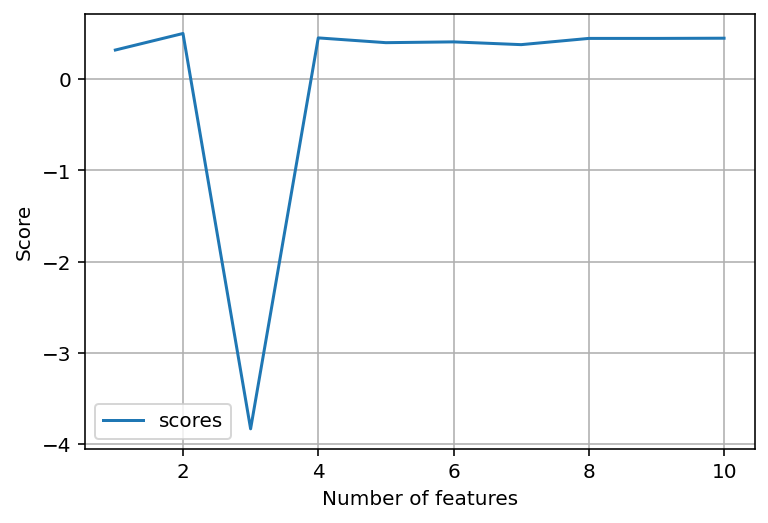

In [26]:
# Plot the GP accuracy in the test set vs. the number of features used to model the problem.

num_features = list(range(1,11))

plt.plot(np.array(num_features), np.array(scores_gp), label='scores')

plt.ylabel('Score')

plt.xlabel('Number of features')

plt.grid()

_=plt.legend()

In [27]:
# Code to answer the second question "Does removing features improve the performance of RF?"

scores_rf = []

for i in range(len(X_train_o[0])):
    model = RandomForestRegressor(n_estimators=10, max_leaf_nodes=10, random_state=42).fit(X_train_o[:,0:i+1], y_train_o)
    scores_rf.append(model.score(X_test_o[:,0:i+1], y_test_o))

scores_rf

[0.28536933041138124,
 0.5062545516917618,
 0.4755841874992831,
 0.48370566725793607,
 0.4754508637763093,
 0.4951170428806192,
 0.49187691027979863,
 0.47249921086542646,
 0.47040303594204713,
 0.4703343755597934]

### Your comments:

**What is the best number of features to model the problem?**

According the the scores obtained when training GP models with the settings of Section1, increasing the number of features in the order suggested by random_forest_order, the **best number of features to model the problem is 2**. The features that return the highest score are those with the highest feature importance value according to RF ('BMI' and 'LTG'). 

**Does removing features improve the performance of RF?**

Yes, removing features does improve the performance of RF. Looking at the list of scores_rf, with only the first 2 features, the model returns the highest possible score (0.5062545516917618). Therefore, we can conclude that if we remove the last 8 features, the performance of the RF model improves. 

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**

Noisy features are those that worsen the performance of the regressors, and looking at the list of scores_gp, it can be seen that the third variable is definately a noisy variable, since it returns a score of -3.8306034723419673, which significantly worsens the performance of the GP. 

### 2.2.2 GP with an ARD kernel

The fitting of a GP endowed with an anisotropic RBF kernel obtains a different value of the `length_scale` for each variable.

**Relate the length scale of each variable with its relevance in the predictive function**

Hint: Consider how does the output of the predictive function changes as the value of a certain variable $x_k$ changes depending on $l_k^2$.

In the next cell write code that fits a GP with an ARD kernel. 

**Print the lengthscale value of each feature after the kernel has been optimized** Hint, learn to use `kernel_get_params()`.** 

**Sort the features in order of decreasing importance in an array called `ARD_order`**

**Print the score in the test set  of the GP with ARD kernel**

In [28]:
# Initialize the ARD kernel 

ard_kernel = RBF(length_scale=np.ones(X_train.shape[1]))

# Fit a GP model using the ARD kernel

model_ard = GaussianProcessRegressor(kernel=ard_kernel, random_state=42).fit(X_train, y_train)

# Print the lengthscale value of each feature after the kernel has been optimized

length_scale = model_ard.kernel_.get_params()['length_scale']
length_scale

array([1.00153163, 1.        , 1.00000383, 1.00000009, 1.00009567,
       1.00024491, 1.00009566, 1.        , 1.00000005, 1.00153163])

In [29]:
# Sort the features in order of decreasing importance 

ARD_order = np.argsort(length_scale)[::-1]
ARD_order

array([9, 0, 5, 4, 6, 2, 3, 8, 7, 1], dtype=int64)

In [30]:
# Print the score in the test set of the GP and ARD kernel

model_ard.score(X_test, y_test)

-3.8306034723413065

In [31]:
# Additional dictionary created to see which variable belongs to which value in the length_scale array

head = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU']

imp = length_scale

# Create an empty dictionary 

d_ard = {}

# Fill in the dictionary 

for i in range(len(head)):
    d_ard[head[i]]  = imp[i]
    
# Store the keys and values in two different variables

keys_ard = list(d_ard.keys())

values_ard = list(d_ard.values())

# Sort the dictionary, so that the features are ordered in decreasing importance

sorted_value_index_ard = np.argsort(values_ard)

sorted_dict_ard = {keys_ard[i]: values_ard[i] for i in sorted_value_index_ard}

my_dict_ard = dict(reversed(sorted_dict_ard.items()))

# Print the dictionary 

my_dict_ard

{'GLU': 1.0015316331674222,
 'AGE': 1.0015316310612168,
 'LDL': 1.0002449071372048,
 'TC': 1.0000956656725075,
 'HDL': 1.0000956603142184,
 'BMI': 1.00000383048267,
 'BP': 1.0000000895523402,
 'LTG': 1.0000000463341645,
 'TCH': 1.0000000000001572,
 'SEX': 1.0}

In the next cell write code that implements a `for loop` that in each iteration trains a GP with an ARD kernel but increasing the number of features in the ordering suggested by `ARD_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

In [32]:
# The first step is to order the data in the same order of the ARD_order array

data_ard = data[list(my_dict_ard.keys())+['Y']]

X_ard = data_ard.values[:,:-1]

Y_ard = data_ard['Y'].values

# Split the data into training and test sets, considering the change in the order of the columns

X_train_ard, X_test_ard, y_train_ard, y_test_ard = train_test_split(X_ard, Y_ard, test_size=0.25, random_state=42)

In [33]:
# Initialize a variable that contains the scores of each GaussianProcessRegressor with ARD kernel

scores_ard = []

# Implement a for loop that in each iteration trains a GP model with an ARD kernel, increasing the number of features in the order suggested by ARD_order

for i in range(len(X_train_ard[0])):
    ard_kernel = RBF(length_scale=np.ones(i+1))
    model = GaussianProcessRegressor(kernel=ard_kernel, random_state=42).fit(X_train_ard[:,0:i+1], y_train_ard)
    scores_ard.append(model.score(X_test_ard[:,0:i+1], y_test_ard))

In [34]:
# Print the list of scores

scores_ard

[0.01062263913232464,
 -1.5849662311452053,
 -1.6509147659781984,
 -1.167567892934981,
 -0.7440159820536079,
 -0.4431787646907699,
 -3.8306034723408677,
 -3.8306034723408775,
 -3.8306034723408775,
 -3.8306034723413065]

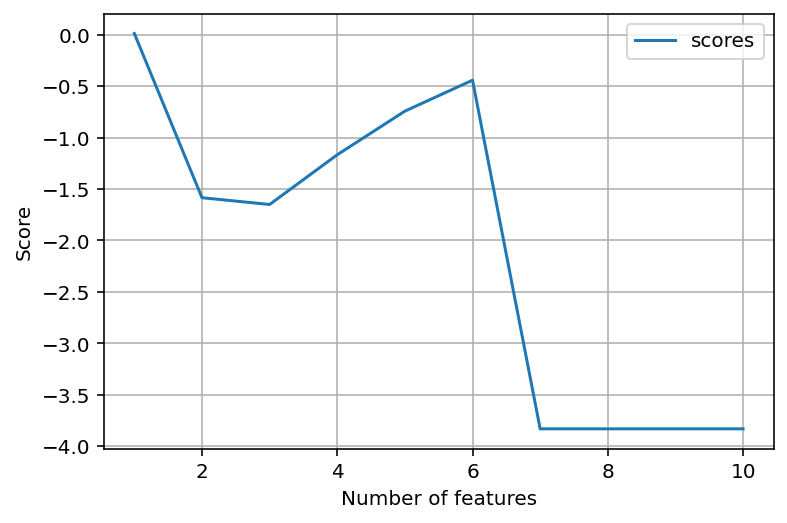

In [35]:
# Plot the GP accuracy in the test set vs. the number of features used to model the problem.

num_features = list(range(1,11))

plt.plot(np.array(num_features), np.array(scores_ard), label='scores')

plt.ylabel('Score')

plt.xlabel('Number of features')

plt.grid()

_=plt.legend()

### Your comments: 

**What is the best number of features to model the problem according to the ARD kernel?**

Looking at the list of scores_ard, we can seen that, in general, the performance of the model is pretty bad. However, if we had to use this kernel, we would say that the **best number of features to model the problem** according to the ARD kernel is **1**, which returns the highest possible score (0.01634511339197553). 

**How stable are the optimizations of the Gaussian Processes with ARD kernels as the number of features increase?**

Looking at the graph, we can clearly see that the optimizations of the Gaussian Process with ARD kernels is very unstable as the number of features increases, until it reaches 7 features and becomes stable. 

**Does removing features improve the performance of GPs?**

Yes, removing features does improve the performance of the Gaussian Processes, because as it can be seen in the list of scores_ard, with just the first variable, we obtain the highest possible score. Therefore, we can conclude that we can remove the last 9 variables. 

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**

Noisy features are those that worsen the performance of the regressors, and looking at the list of scores_ard, it can be seen that the all the variables except for the first one are noisy variables, since all of them have negative scores, which significantly worsen the performance of the Gaussian Process. 

**How does the feature selection suggested by the ARD kernel compare with that suggested by random forest?**

Comparing best number of features to model the problem:

The feature selection process suggested by the ARD kernel says that with only the first feature ('GLU'), the highest possible score is returned, while the feature selection process suggested by random forest says that with the first two variables ('BMI' and 'LTG'), the highest possible score of the model is returned. Moreover, it can be seen that the most relevant variables in each model do not coincide, ARD kernel suggests that the most relevant variables is 'GLU', while the random forest says that the most relevant variables are 'BMI' and 'LTG'. One interesting thing that we noticed was that 'BMI' and 'LTG' are not that relevant according to the feature selection suggested by ARD kernal. Finally, comparing the performance achieved by each model using the best number of features according to feature selection, the score of the random forest model is considerably higher than that of the ARD kernel. 

    Score using most relevant variables given by the feature selection suggested by ARD kernel --> 0.0163
    
    Score of using most relevant variables given by the feature selection suggested by random forest --> 0.50625

# 4. Exploring sophisticate kernels for the GP

The greatest potentiality of GPs are the exploration of different kernels that capture the geometry of the inputs. 

Besides, the essential kernels can be combined into more sophisticate ones using the addition and multiplication operations.

And the most interesting feature, the GP implementation is able to optimize the parameters of the kernel maximizing the likelihood of the observations, what saves the crossvalidation step for optimizing parameters.

Read the [section 1.7.5 of this site](https://scikit-learn.org/stable/modules/gaussian_process.html) to learn the different kernels that are implemented in the scikit learn distribution of Gaussian Processes.

In this section check at least twenty different kernel configurations and evaluate if they improve the kernel evaluated in section 1. Remember this kernel was

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Within the kernel combinations to explore you can include:
1. Replace $\kappa_r(\mathbf x_i, \mathbf x_j)$ by an anisotropic RBF in $\kappa_1(\mathbf x_i, \mathbf x_j)$. 

3. Individual kernels presented in the lecture

4. Addition of several kernels

5. Multiplication of several kernels

6. Use your imagination!

We will use the different kernel combinations to characterize how difficult is the problem at hand in terms of how difficult is to find out a kernel that achieves the best possible result in the test set.

For this purpose:
1. Group in a same array all the scores in the **test set** achieved by all the kernel combinations that you explore in this section. Consider carrying out this exploration in a programatic fashion. As a suggestion, program nested loops that create composite kernels as combination of simple kernels.

2. Discuss about the range of test accuracies that can be reached with GPs when the kernel is more carefully designed. Depending on the number of different kernels explored you might consider adding to your discussion
- minimum, maximum, mean values
- standard deviations
- percentiles
- histogram

In [36]:
# Initialize all the possible kernels that will be used during the generation of the 20 different kernels 

# We are selecting arbitrary values for the different parameters of each kernel

kernels = ['DotProduct(sigma_0=5)', 'ExpSineSquared(length_scale=100, periodicity=5)', 
           'RationalQuadratic(alpha=5,length_scale=100)', 'Matern(length_scale=100)', 
           'RBF(length_scale=100)', 'WhiteKernel(noise_level=3)', 'ConstantKernel()']

# Initialize the possible operators that could appear, which are sum and product

operators = ["+", "*"]

# This list contains the five first individual kernels that will be used, and it will be expanded with the rest of the kernels 

ker = ['DotProduct(sigma_0=5)', 'ExpSineSquared(length_scale=100, periodicity=5)', 'RationalQuadratic(alpha=5, length_scale=100)', 'Matern(length_scale=100)', 'RBF(length_scale=np.ones(X_train.shape[1]))']


# Create a loop that generates random combinations of kernels and appends them to the ker list

random.seed(43)

for i in range(15):
    k1 = random.randint(0,6)
    k2 = random.randint(0,6)
    o = random.randint(0,1)
    ker.append(kernels[k1]+operators[o]+kernels[k2])

# Print the list of all the different kernels that will be used when fitting the Gaussian Process Regressors

ker

['DotProduct(sigma_0=5)',
 'ExpSineSquared(length_scale=100, periodicity=5)',
 'RationalQuadratic(alpha=5, length_scale=100)',
 'Matern(length_scale=100)',
 'RBF(length_scale=np.ones(X_train.shape[1]))',
 'DotProduct(sigma_0=5)+RationalQuadratic(alpha=5,length_scale=100)',
 'Matern(length_scale=100)+RationalQuadratic(alpha=5,length_scale=100)',
 'Matern(length_scale=100)*RBF(length_scale=100)',
 'RBF(length_scale=100)*DotProduct(sigma_0=5)',
 'RBF(length_scale=100)*RationalQuadratic(alpha=5,length_scale=100)',
 'Matern(length_scale=100)+ExpSineSquared(length_scale=100, periodicity=5)',
 'ConstantKernel()+DotProduct(sigma_0=5)',
 'Matern(length_scale=100)+ExpSineSquared(length_scale=100, periodicity=5)',
 'ExpSineSquared(length_scale=100, periodicity=5)*RBF(length_scale=100)',
 'ExpSineSquared(length_scale=100, periodicity=5)*ConstantKernel()',
 'RBF(length_scale=100)*RBF(length_scale=100)',
 'RBF(length_scale=100)*ExpSineSquared(length_scale=100, periodicity=5)',
 'DotProduct(sigma_0=5

In [37]:
# Initialize an empty list that will contain the scores of each one of the models with the different kernels

test_scores = []

# Iterate through the list so that a Gaussian Process Regressor is generated for each kernel and append its score to the list test_scores
for i in ker:
    model = GaussianProcessRegressor(kernel=eval(i), alpha=1, random_state=42).fit(X_train, y_train)
    test_scores.append(model.score(X_test, y_test))

# Print the test_scores

test_scores

[0.4810439027094696,
 -0.01162530684467944,
 0.3369973651660354,
 0.40190365454458976,
 -3.8306034723416422,
 0.4810841069890611,
 0.27006793281478847,
 0.4019037099232998,
 -3.8306034723419673,
 0.3375453049574909,
 0.3218789271240138,
 0.48104794045747945,
 0.3218789271240138,
 0.4059604552503724,
 -3.8306034723419673,
 0.410292574151226,
 0.4005754421021783,
 0.4815550090052406,
 0.4782217772110089,
 0.3362237263790393]

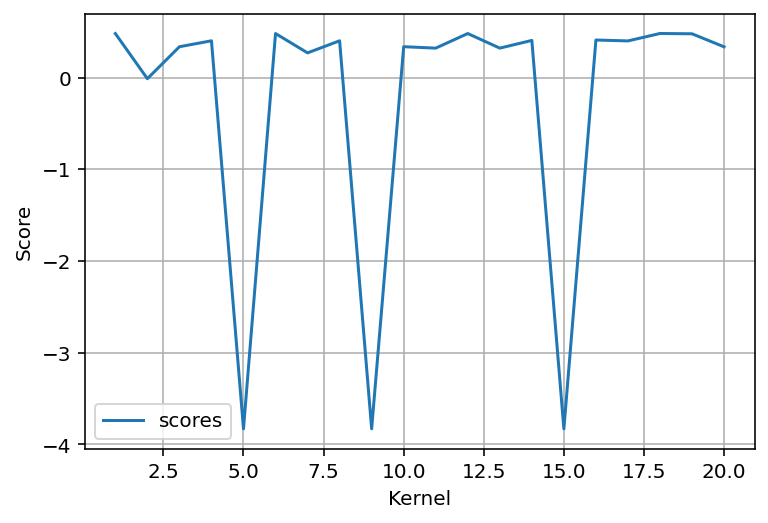

In [38]:
# Plot the scores in the test set of all the models vs. the kernel

num_features = list(range(1,21))

plt.plot(np.array(num_features), np.array(test_scores), label='scores')

plt.ylabel('Score')

plt.xlabel('Kernel')

plt.grid()

_=plt.legend()

In [39]:
# Highest score out of all in the test_scores list

print('Highest score in the list:',max(test_scores))
print("")
print('Index of highest score in the list:',test_scores.index(max(test_scores)))
print("")
print('Kernel that returned the highest score in the list:', ker[test_scores.index(max(test_scores))])

Highest score in the list: 0.4815550090052406

Index of highest score in the list: 17

Kernel that returned the highest score in the list: DotProduct(sigma_0=5)+DotProduct(sigma_0=5)


## Discussion

In this section, we created a loop that automatically and randomly generated different combinations of kernels. In the list test_scores, we can see the performance of each Gaussian Process with their respective kernels, and some of them are good, but others are very bad. 

The highest possible score obtained in the randomly generated kernels was **0.48154352705450754** using the following kernel **DotProduct(sigma_0=5)+DotProduct(sigma_0=5)**. Comparing this result with the one obtained in Section 1 with a more carefully designed kernel (score=0.44867154722059155 and kernel=ConstantKernel()*RBF(length_scale=1.5, length_scale_bounds=[1e-2, 1e3])+ WhiteKernel(noise_level=0.1, noise_level_bounds=[1e-10, 1e6])), we can see that the score obtained in this section is slightly higher than that of the first section.

Moreover, looking at all the previous results from the notebook, we can conclude that the best possible model was the one obtained with scaled data, without using GP optimization, and using the kernel specified in the first section, which returned a score of around 0.53. This score of Section 2 is slightly better than the one obtained for the automatically and randomly generated kernel. 

Finally, we can conclude that the randomly generated kernel with highest performance without carefully designing it and tuning its parameters, returned an overall performance of around a 5% lower than the best score obtained in the whole notebook (mentioned above). However, the performance is slightly better than the one obtained in section 1, which could have been just luck, and maybe if we would have carefully designed the kernel, like we did in Section 1, we could have been able to improve the highest score obtained in the notebook. 

# Items for discussion

- Which strategy turned out to be the best in terms of increasing the performance of the GP? 

The strategy that turned out to be the best in terms of increasing the performance of the GP was scaling the data and setting the **optimizer** of the Gaussian Process Regressor function equal to **None**, that is, without using GP optimization. This strategy returned the highest score out of all the strategies applied in this notebook; the score returned was around 0.53. 

- Did this strategy performed significantly better than the others?

The performance of this strategy was the best out of all the models; nevertheless, the difference was not significant with respect to the second and third best models. For instance, the second best model was the one obtained using the randomly generated kernel, which returned a score of around 0.48. The third best model was the one obtained using the kernel defined in section 1 and the optimizer, which returned a score of around 0.44. Therefore, this shows that even though there was a difference between the scores, it was not significant between the best models. Nevertheless, if we compare, for example, the first model created in section 1 that did not use a GP optimizer, there is no doubt that the difference is significant, since the score of this model was around -3.8. 

- Kernel design pushes the GP model further into the **black box method** region, what is the price you pay for sticking to the more interpretable ARD kernel in terms of accuracy? 

The price that you pay for sticking to the more interpretable ARD kernel, is that you will obtain pretty bad scores, that is, the performance of the model using this kernel will be bad, or at least, it will not be the best. However, depending on the characteristics and objectives of each problem, it may be better to use a kernel that you know will not produce the best GP model in terms of accuracy and performance, but to have a model and a kernel that you can easily interpret and understand, and be able to extract some or more conclusions from it. 